In [71]:
"""
Preprocesses the input data frame by imputing missing values with median, standardizing the features, and applying PCA for dimensionality reduction.

Fits a KMeans clustering model on the PCA-transformed data and plots the clusters.
"""

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import silhouette_score


def preprocess(df):
    imputer = SimpleImputer(strategy="median")
    imputed_df = pd.DataFrame(imputer.fit_transform(df))
    scaled_df = StandardScaler().fit_transform(imputed_df)
    return scaled_df


def display_loadings(fitted_pca, features, figsize=(3, 10), component=0):
    loadings = fitted_pca.components_
    order = np.argsort(abs(loadings[component, :]))[::]  # Reverse the order
    loadings = loadings[:, order]
    features = [features[i] for i in order]

    loadings = pd.Series(loadings[component, :], index=features)
    fig, ax = plt.subplots(figsize=figsize)
    loadings.plot(kind="barh", ax=ax)

    return loadings


df = pd.read_csv("data/DS_salary_factors.csv", na_values=0)
df["GeoFips"] = df["GeoFips"].astype(str)

# Features selected by Nate
feature_names = [
    "2022 GDP",
    "Total Employment in State/Area",
    "2022 Median",
    "Poverty Percent",
    "Per Bach or Higher",
    "Uninsured",
    "2020 Life Expect",
    "Violent crime rate per 100,000 people",
    "Property crime rate per 100,000 people",
    "percent formal_vol",
    "percent Good Air Quality Days",
    "Gas Tax (cents)",
    "Internet Access Percent 2021",
    "Happiness",
    "A_MEDIAN",
]


In [14]:
# numeric_features = df.select_dtypes(include="number").columns


X = df[feature_names]


In [23]:
X = preprocess(X)
pca = PCA().fit(X)
X_pca = pca.transform(X)
captures_80 = (np.argwhere(pca.explained_variance_ratio_.cumsum() > 0.8) + 1).min()


In [59]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import spectral_clustering, AgglomerativeClustering, DBSCAN, OPTICS

# calculate silhoutte scores for k 2 to k 7
# repeat for kmeans and gmm

k_values = range(2, 8)
n_components = range(2, 8)
silhouette_scores = pd.DataFrame(
    columns=["Clusterer", "K", "N_components", "Silhouette"]
)
for c in n_components:
    for k in k_values:
        # KMeans
        X_pca = PCA(n_components=c).fit(X).transform(X)
        kmeans_cluster = KMeans(n_clusters=k, random_state=0).fit(X_pca)
        kmeans_labels = kmeans_cluster.labels_
        kmeans_score = silhouette_score(X_pca, kmeans_labels)
        new_row = pd.DataFrame(
            data=[["kmeans", k, c, kmeans_score]],
            columns=["Clusterer", "K", "N_components", "Silhouette"],
        )

        silhouette_scores = pd.concat([silhouette_scores, new_row])

        # GaussianMixture
        gmm_cluster = GaussianMixture(n_components=k).fit(X_pca)
        gmm_labels = gmm_cluster.predict(X_pca)
        gmm_score = silhouette_score(X_pca, gmm_labels)
        new_row = pd.DataFrame(
            data=[["GMM", k, c, gmm_score]],
            columns=["Clusterer", "K", "N_components", "Silhouette"],
        )

        silhouette_scores = pd.concat([silhouette_scores, new_row])

        # Spectral
        spectral_cluster = SpectralClustering(
            n_clusters=k,
        ).fit(X_pca)
        spectral_clustering_labels = spectral_cluster.labels_
        spectral_clustering_score = silhouette_score(X_pca, spectral_clustering_labels)
        new_row = pd.DataFrame(
            data=[["Spectral", k, c, spectral_clustering_score]],
            columns=["Clusterer", "K", "N_components", "Silhouette"],
        )
        # Agglomerative
        agglom_cluster = AgglomerativeClustering(
            n_clusters=k,
        ).fit(X_pca)
        agglom_labels = agglom_cluster.labels_
        agglom_score = silhouette_score(X_pca, agglom_labels)
        new_row = pd.DataFrame(
            data=[["Agglomerative", k, c, agglom_score]],
            columns=["Clusterer", "K", "N_components", "Silhouette"],
        )

        silhouette_scores = pd.concat([silhouette_scores, new_row])
        # DBSCAN
        dbscan_cluster = OPTICS(min_samples=30).fit(X_pca)
        dbscan_labels = dbscan_cluster.labels_
        if len(np.unique(dbscan_labels)) <= 1:
            dbscan_score = -1
        else:
            dbscan_score = silhouette_score(X_pca, dbscan_labels)

        new_row = pd.DataFrame(
            data=[["DBSCAN", k, c, dbscan_score]],
            columns=["Clusterer", "K", "N_components", "Silhouette"],
        )
    silhouette_scores = pd.concat([silhouette_scores, new_row])

silhouette_scores.sort_values("Silhouette", ascending=False, inplace=True)
silhouette_scores.reset_index(drop=True, inplace=True)
silhouette_scores.head(50)


/tmp/ipykernel_352549/1077566550.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  silhouette_scores = pd.concat([silhouette_scores, new_row])


,Clusterer,K,N_components,Silhouette
0,kmeans,2,2,0.447602
1,Agglomerative,2,2,0.435037
2,GMM,2,2,0.428467
3,kmeans,3,2,0.424344
4,Agglomerative,3,2,0.408917
5,kmeans,4,2,0.402274
6,kmeans,5,2,0.400898
7,kmeans,6,2,0.399334
8,GMM,3,2,0.372327
9,kmeans,7,2,0.369838


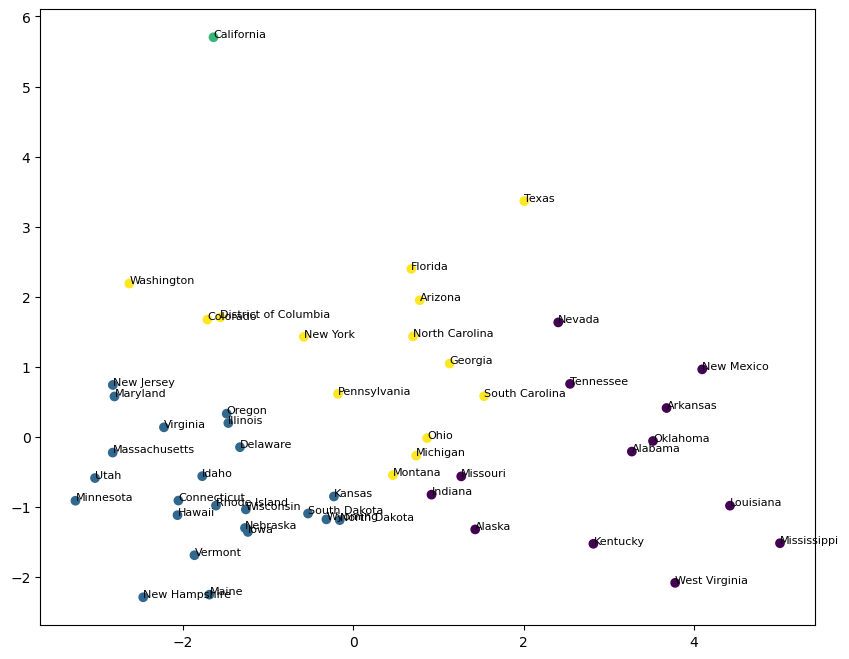

In [62]:
# cluster = KMeans(n_clusters=4, random_state=0).fit(X_pca)
# cluster = SpectralClustering(n_clusters=4, random_state=0).fit(X_pca)
cluster = KMeans(4).fit_predict(X_pca[:, :2])

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster, cmap="viridis")
for i, label in enumerate(df.GeoName):
    ax.text(X_pca[i, 0], X_pca[i, 1], label, fontsize=8)


Poverty Percent                                             -0.000372
Total Civilian Non-Institutional Population in State/Area   -0.019449
2022 Median                                                  0.081001
2022 GDP                                                    -0.100565
Per Bach or Higher                                          -0.104456
Percent (%) of Labor Force Unemployed in State/Area          0.199786
Poverty (thousands)                                         -0.202926
Employer Insured                                            -0.208514
Percent (%) of Labor Force Employed in State/Area            0.243715
Medicaid Insured                                            -0.265959
Total Employment in State/Area                              -0.322166
Non-Group Insured                                           -0.380444
Total Civilian Labor Force in State/Area                    -0.381703
Total Unemployment in State/Area                            -0.401457
Percent (%) of State

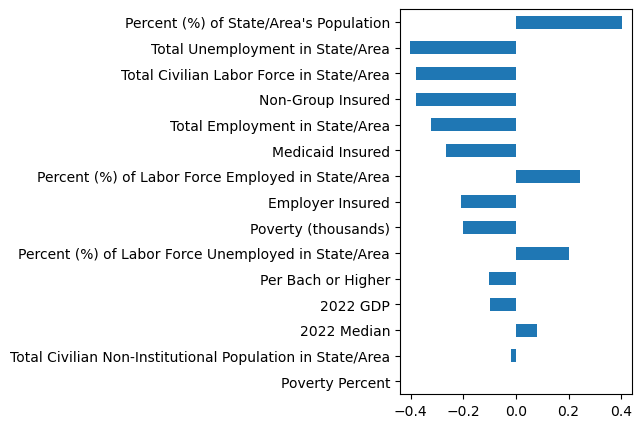

In [75]:
display_loadings(pca, numeric_features, figsize=(3, 5), component=0)


Total Unemployment in State/Area                             0.062157
Non-Group Insured                                            0.093815
Total Civilian Labor Force in State/Area                     0.097949
Percent (%) of State/Area's Population                       0.124303
Total Employment in State/Area                               0.147039
Employer Insured                                            -0.178594
Percent (%) of Labor Force Employed in State/Area            0.208764
Per Bach or Higher                                           0.220756
Medicaid Insured                                             0.263256
Percent (%) of Labor Force Unemployed in State/Area          0.276724
Poverty (thousands)                                         -0.296955
2022 GDP                                                     0.313653
2022 Median                                                  0.323749
Poverty Percent                                             -0.337715
Total Civilian Non-I

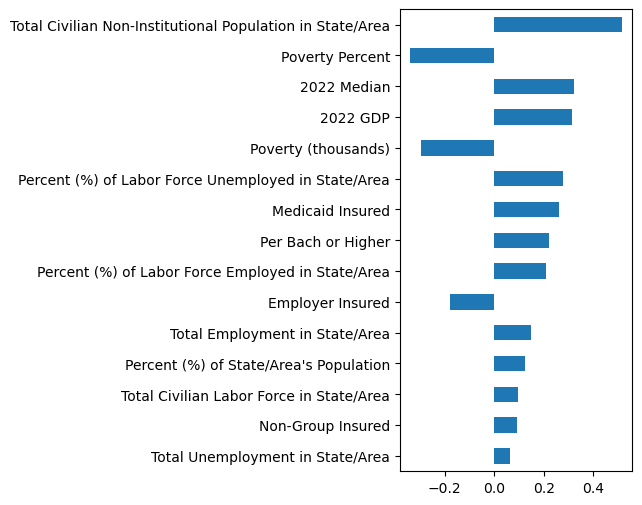

In [78]:
display_loadings(pca, numeric_features, figsize=(3, 6), component=1)


In [88]:
df["GeoFips"] = df["GeoFips"].str.pad(5, "left", "0")
